## Entropy Vectors

In this notebook, we explore the usage of entropy vectors as an alternative to class histograms when analysing neurons in a neural network layer.

To compute the entropy vector of a neuron $N$, we do as follows: For a given class $c_i$, we compute the histogram of the activation values generated by inputs belonging to $c_i$ in the training set. For example, lets say we have 10 elements of said class in the training set and these 10 elements generate the following activation values in $N$: 0, 1, 1, 2, 2, 2, 3, 3, 3, 4. In this case, the histogram of $N$ for class $c_i$ would have 5 bins (0, 1, 2, 3, 4) with sizes (1, 2, 3, 3, 1) respectively. 

Of course, in practice the activation values are float numbers spread over a much larger range. So some discretization is needed in order to build the histogram. We leave this decision to the analyst.

After calculating this histogram for every class $c_i$ in the dataset, we calculate the entropy $e_i$ of each one of these histograms. This set of entropies form a $C$-dimensional vectors where $C$ is the number of classes in the training set, which we call entropy vector.

This approach is motivated by the assumption that not necessarily a neuron must generate high activations for a class for being specialized on that class or a least to identify features of that class. For instance, if a neuron constantly outputs values inside a small range (e.g., between 20 and 25) for a given class $c_i$, while generating much different values for elements of other classes (e.g., lets say, all other classes output values higher than 50), than this neuron likely is very effective in identifying inputs from $c_i$, even though it actually has a small activation in that class.

As we want to give more importance in the entropy vector to classes which the histogram comprises a smaller range as possible, we do some normalization in the entropy vector. First, we normalize them between 0 and 1, dividing each entropy value by the highest entropy value. Then we do $1 - e$ ($e$ is the entropy vector), so that classes which the histogram has lower entropy will have higher values in the entropy vector (as these are the classes we are more interested in). Finally, we divide the whole vector by the sum of all values in the vector.



In [7]:
# Importing some libraries.
import numpy as np
import random
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.optimizers import rmsprop, SGD, Adadelta

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import entropy

In [3]:
# Set random seed for reproducibility.
np.random.seed(0)
random.seed(0)

# Fetch CIFAR-10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Dataset information.
num_train, height, width, depth = x_train.shape
num_test = x_test.shape[0]
num_classes = np.unique(y_train).shape[0]

# Normalise data to [0, 1] range.
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train /= np.max(x_train)
x_test /= np.max(x_test)

# One-hot encode the labels.
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Dataset labels.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In this experiment, we train a network with 6 convolutional layers and 1 hidden layer. The architecture is described below:

In [4]:
# Set random seed for reproducibility.
np.random.seed(0)
random.seed(0)

# Set hyperparameters.
kernel_size = 3    # We use 3x3 kernels throughout the convolutions.
pool_size = 2      # We use 2x2 pooling throughout the pooling layers.
conv_depth_1 = 32  # We initially have 32 kernels per conv. layer.
conv_depth_2 = 64  # Switching to 64 after the first pooling layer.
conv_depth_3 = 128 # Switching to 128 after the second pooling layer.
drop_prob_1 = 0.25 # Dropout after pooling with probability 0.25
drop_prob_2 = 0.5  # Dropout in the dense layer with probability 0.5
hidden_size = 32   # The dense layer will have 32 neurons

# Define layers of the first convolutional step.
conv_1 = Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same', 
                activation='relu', input_shape=(height, width, depth))
conv_2 = Conv2D(conv_depth_1, (kernel_size, kernel_size), activation='relu')
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))
drop_1 = Dropout(drop_prob_1)

# Define layers of the second convolutional step.
conv_3 = Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')
conv_4 = Conv2D(conv_depth_2, (kernel_size, kernel_size), activation='relu')
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))
drop_2 = Dropout(drop_prob_1)

# Define layers of the third convolutional step.
conv_5 = Conv2D(conv_depth_3, (kernel_size, kernel_size), padding='same', activation='relu')
conv_6 = Conv2D(conv_depth_3, (kernel_size, kernel_size), activation='relu')
pool_3 = MaxPooling2D(pool_size=(pool_size, pool_size))
drop_3 = Dropout(drop_prob_1)

# Define layers of the classification step.
flat_1 = Flatten()
dens_1 = Dense(hidden_size, activation='relu')
drop_4 = Dropout(drop_prob_2)
output = Dense(num_classes, activation='softmax')

# Instantiate the model.
model = Sequential()
model.add(conv_1)
model.add(conv_2)
model.add(pool_1)
model.add(drop_1)
model.add(conv_3)
model.add(conv_4)
model.add(pool_2)
model.add(drop_2)
model.add(conv_5)
model.add(conv_6)
model.add(pool_3)
model.add(drop_3)
model.add(flat_1)
model.add(dens_1)
model.add(drop_4)
model.add(output)

In [5]:
# Compile and train the model.
model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
h = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 153s 3ms/step - loss: 1.9878 - acc: 0.2520 - val_loss: 1.6410 - val_acc: 0.3856
Epoch 2/10
45000/45000 [==============================] - 205s 5ms/step - loss: 1.5726 - acc: 0.4301 - val_loss: 1.3973 - val_acc: 0.4956
Epoch 3/10
45000/45000 [==============================] - 151s 3ms/step - loss: 1.3936 - acc: 0.5118 - val_loss: 1.1747 - val_acc: 0.5976
Epoch 4/10
45000/45000 [==============================] - 165s 4ms/step - loss: 1.2679 - acc: 0.5627 - val_loss: 1.3221 - val_acc: 0.5528
Epoch 5/10
45000/45000 [==============================] - 150s 3ms/step - loss: 1.1824 - acc: 0.5951 - val_loss: 1.0881 - val_acc: 0.6282
Epoch 6/10
45000/45000 [==============================] - 153s 3ms/step - loss: 1.1061 - acc: 0.6265 - val_loss: 0.9739 - val_acc: 0.6616
Epoch 7/10
45000/45000 [==============================] - 147s 3ms/step - loss: 1.0554 - acc: 0.6456 - val_loss: 0.9269 - v

In [6]:
# Get predictions for the train set.
p_labels = np.argmax(model.predict(x_train), axis=1)
t_labels = np.argmax(y_train, axis=1)

# Check accuracy.
scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 67.77%


In [10]:
# Calculate the activations of the hidden dense layer.
activations = layer_activation(model, 13, x_train)

In [34]:
# Calculate the entropy vectors for the hidden dense layer.
entropy_vectors = entropy_vectors_dense(activations, t_labels, num_classes)

In [35]:
# Project the entropy vectors from the hidden dense layer.
projection, divergence = project_histogram(entropy_vectors, 10)
print(projection.shape, divergence)

(32, 2) 0.3404732942581177


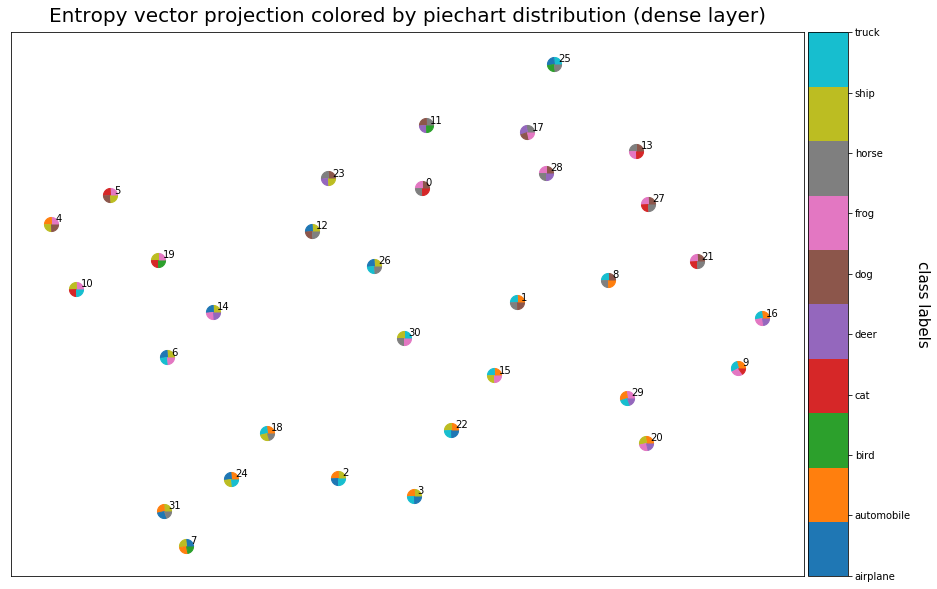

In [60]:
# Plot the entropy vectors from the dense layer using piecharts to color it.
plot_projection_piechart(projection, entropy_vectors, 4, labels, 'dense', im)

In [61]:
# Calculate the activations of the last conv layer.
activations = layer_activation(model, 9, x_train)

In [74]:
# Calculate the entropy vectors for the hidden dense layer.
entropy_vectors = entropy_vectors_conv(activations, t_labels, num_classes)

In [82]:
# Project the entropy vectors from the hidden dense layer.
projection, divergence = project_histogram(entropy_vectors, 30)
print(projection.shape, divergence)

(128, 2) 0.1838306039571762


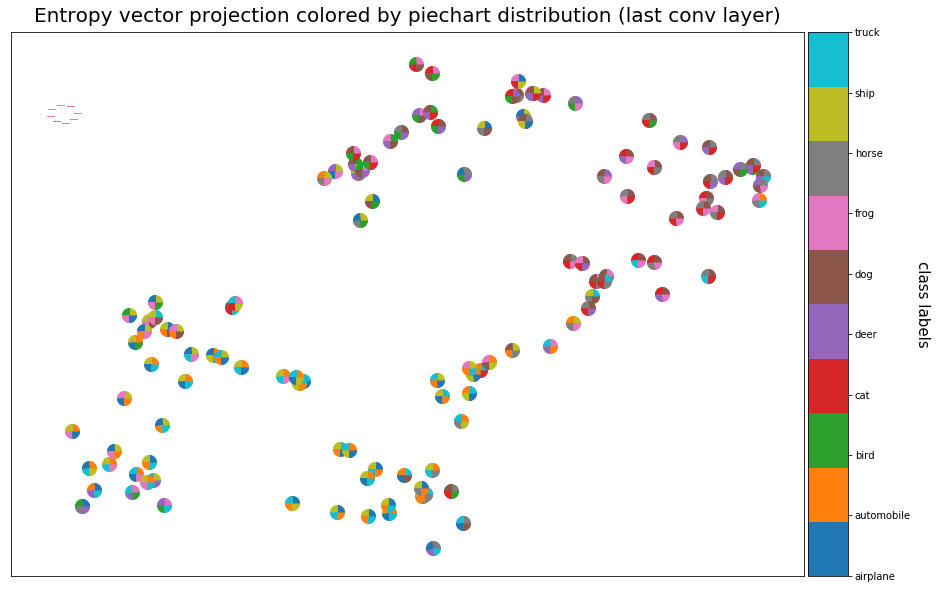

In [83]:
# Plot the entropy vectors from the last conv layer using piecharts to color it.
plot_projection_piechart(projection, entropy_vectors, 4, labels, 'last conv', im)

In [8]:
# Calculate activation vectors in the l-th layer for a given test set.
def layer_activation(model, l, x_test):
    p_model = Sequential()
    
    for i in range(l+1):
        p_model.add(model.layers[i])
    
    activations = p_model.predict(x_test)
    
    return activations

In [33]:
# Calculate the entropy vectors for each unit.
def entropy_vectors_dense(activations, t_labels, num_classes):
    num_units = activations.shape[1]
    
    # Build the the entropy vectors.
    entropy_vectors = np.zeros((num_units, num_classes))
    
    for u in range(num_units):
        # Histograms of each class goes from 0 to the max of the unit (not just the class).
        v_max = np.max(activations[:, u]) + 1
        
        d_rate = 100
        histograms = np.zeros((num_classes, d_rate))
        
        for c in range(num_classes):
            actvs = activations[t_labels == c, u]
            
            for a in actvs:
                histograms[c, int(math.floor(d_rate*a/v_max))] += 1
            
            entropy_vectors[u, c] = entropy(histograms[c, :])
        
        entropy_vectors[u, :] = 1 - entropy_vectors[u, :]/np.max(entropy_vectors[u, :])
        entropy_vectors[u, :] = entropy_vectors[u, :]/np.sum(entropy_vectors[u, :])
    
    return entropy_vectors

In [73]:
# Calculate the entropy vectors for each unit.
def entropy_vectors_conv(activations, t_labels, num_classes):
    num_units = activations.shape[3]
    
    # Build the the entropy vectors.
    entropy_vectors = np.zeros((num_units, num_classes))
    
    for u in range(num_units):
        # Histograms of each class goes from 0 to the max of the unit (not just the class).
        v_max = np.max(activations[:, :, :, u]) + 1
        
        d_rate = 100
        histograms = np.zeros((num_classes, d_rate))
        
        for c in range(num_classes):
            actvs = np.average(activations[t_labels == c, :, :, u], axis=(1,2))
            
            for a in actvs:
                histograms[c, int(math.floor(d_rate*a/v_max))] += 1
            
            entropy_vectors[u, c] = entropy(histograms[c, :])
        
        if np.max(entropy_vectors[u, :]) > 0:
            entropy_vectors[u, :] = 1 - entropy_vectors[u, :]/np.max(entropy_vectors[u, :])
            entropy_vectors[u, :] = entropy_vectors[u, :]/np.sum(entropy_vectors[u, :])
    
    return entropy_vectors

In [12]:
# Project the class histograms from a layer to bidimensional space using t-SNE.
def project_histogram(histograms, p=30, e=12.0):
    tsne = TSNE(perplexity=p, early_exaggeration=e, learning_rate=200.0).fit(histograms)
    projection = tsne.embedding_
    return projection, tsne.kl_divergence_

In [80]:
# Plot the class histogram projection using pie-charts to represent each unit/datapoint.
def plot_projection_piechart(projection, histograms, n, labels, l_type, im):
    f, ax = plt.subplots(figsize=(15, 10))

    # Transform histogram data into pie chart.
    h = np.zeros((histograms.shape[0], n))
    c = np.zeros((histograms.shape[0], n)).astype(int)

    for i in range(h.shape[0]):
        c[i, :] = np.argsort(histograms[i, :])[::-1][:n]
        h[i, :] = histograms[i, c[i, :]]
        
        s = np.sum(h[i, :])
        if s > 0:
            h[i, :] /= s
        
        for j in range(1, h.shape[1]):
            h[i, j] += h[i, j-1]

    # Plot piecharts.
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            if j == 0:
                a = 0
            else:
                a = 2*np.pi*h[i, j-1]

            b = 2*np.pi*h[i, j]

            x = [0] + np.cos(np.linspace(a, b, 10)).tolist()
            y = [0] + np.sin(np.linspace(a, b, 10)).tolist()
            xy = np.column_stack([x, y])

            ax.scatter(projection[i,0], projection[i,1], marker=(xy, 0), s=200, c=cm.tab10(c[i,j]))
    
#     # Plot unit indexes.
#     for i, p in enumerate(projection):
#         ax.annotate(str(i), (p[0] + 2, p[1] + 2))
    
    # Plot the colorbar.
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    cbar = f.colorbar(im, cax=cax)
    cbar.ax.set_yticklabels(labels)
    cbar.ax.set_ylabel("class labels", rotation=-90, va="bottom", fontsize=15)

    # Set titles.
    ax.set_title('Entropy vector projection colored by piechart distribution (' + l_type + ' layer)', 
                 fontsize=20, pad=10)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()